In [ ]:
# 📂 Dataset Download Link (Required to run this notebook):
# https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

In [ ]:
# Uncomment the below line if running for the first time

# %pip install pandas numpy matplotlib pillow

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
# Functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / exps.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12  # to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [ ]:
# Layer Class
class Layer:
    def __init__(self, number, size):
        self._number = number
        self._size = size
        self._data = None

    @property
    def number(self):
        return self._number

    @property
    def size(self):
        return self._size

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, new_data):
        if new_data.shape[1] == self._size:
            self._data = new_data
        else:
            raise ValueError("Shape mismatch while setting layer data.")

In [ ]:
# Weight Class
class Weight:
    def __init__(self, from_layer, to_layer):
        self._value = np.random.randn(from_layer.size, to_layer.size) * np.sqrt(2. / from_layer.size)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting weight value.")

# Bias Class
class Bias:
    def __init__(self, to_layer):
        self._value = np.zeros((1, to_layer.size), dtype=np.float32)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting bias value.")

In [63]:
# Neural Network Class
class NN:
    def __init__(self, learning_rate=0.01):

        self._learning_rate = learning_rate
        self._layers = []
        self._weights = []
        self._biases = []
        self._deltas = []
        self._zs = []
        self._djdw = []
        self._djdb = []
        self._activation = None

    def add_layer(self, layer):
        self._layers.append(layer)
        if len(self._layers) > 1:
            self._weights.append(Weight(self._layers[-2], self._layers[-1]))
            self._biases.append(Bias(self._layers[-1]))

    def forward(self):
        self._zs = [None] * len(self._layers)
        for i in range(1, len(self._layers)):

            prev_data = self._layers[i-1].data
            w = self._weights[i-1].value
            b = self._biases[i-1].value

            z = np.dot(prev_data, w) + b
            self._zs[i] = z

            if i == len(self._layers) - 1:
              activated = softmax(z)
            else:
              activated = relu(z)

            self._layers[i].data = activated

    @property
    def output(self):
        return self._layers[-1].data

    @property
    def delta(self):
        return self._deltas

    @delta.setter
    def backpropagation(self, target):
        self._deltas = [None] * len(self._layers)
        self._djdw = [None] * len(self._weights)
        self._djdb = [None] * len(self._biases)

        output = self._layers[-1].data
        z_last = self._zs[-1]
        if z_last is None:
            raise ValueError("Last layer is None. Ensure forward() is called before setting delta.")
        self._deltas[-1] = (output - target)

        for i in range(len(self._layers) - 2, 0, -1):
            next_w = self._weights[i].value
            next_delta = self._deltas[i + 1]
            z = self._zs[i]
            self._deltas[i] = np.dot(next_delta, next_w.T) * relu_derivative(z)

        # djdw and djdb calculation
        for i in range(len(self._weights)):
            a_prev = self._layers[i].data
            delta_curr = self._deltas[i + 1]
            self._djdw[i] = np.dot(a_prev.T, delta_curr)
            self._djdb[i] = np.sum(delta_curr, axis=0, keepdims=True)
    @property
    def djdw(self):
        return self._djdw

    @property
    def djdb(self):
        return self._djdb

    def update(self):
      clip_value = 1.0
      for i in range(len(self._weights)):
        # Clip gradients
        self._djdw[i] = np.clip(self._djdw[i], -clip_value, clip_value)
        self._djdb[i] = np.clip(self._djdb[i], -clip_value, clip_value)

        # Apply updates
        self._weights[i].value -= self._learning_rate * self._djdw[i]
        self._biases[i].value -= self._learning_rate * self._djdb[i]



In [64]:
# Load Dataset
file_name = 'mnist_train.csv'
df = pd.read_csv(file_name)

labels = df['label'].values
pixels = df.drop('label', axis=1).values.astype(np.uint8)

In [ ]:
# Input Batch Setup

n = len(labels)
idxs = list(range(n))



In [ ]:
# (If you want to take small batch of inputs(in case you don't run on gpu), comment out above block of code and uncomment this below code)

# # For Small Batch Input
# n = int(input("Enter the batch size of images : "))
# max_idx = len(labels) - 1
# if not (0 <= n <= max_idx):
#     raise ValueError(f"Batch size exceeded the original size. Must be between 0 and {max_idx}.")
# idxs = list(range(n))


In [66]:
# # Display All Images(Only uncomment if taking a small batch of input and want to see the images)

# for idx in idxs:
#     print(f"{idx+1}. Label: {labels[idx]}")
#     display(Image.fromarray(pixels[idx].reshape(28, 28), mode='L'))


In [67]:
# Normalize and Prepare Input Batch
images = pixels[idxs].astype(np.float32) / 255.0
targets = np.zeros((n, 10), dtype=np.float32)
for i in range(n):
    targets[i, labels[idxs[i]]] = 1

# Initialise Network
net = NN()
input_layer = Layer(1, 784)
input_layer.data = images
net.add_layer(input_layer)

net.add_layer(Layer(2, 107))
net.add_layer(Layer(3, 26))
net.add_layer(Layer(4, 10))

track_cost = []

In [68]:
# Training the Network
training_rounds = 200

for i in range(training_rounds):
    net.forward()

    # Delta Calculation
    net.backpropagation = targets

    # Update Weights and Biases
    net.update()

    # Track Cost
    current_cost = cross_entropy_loss(net.output, targets)
    track_cost.append(current_cost)

    # Print progress every 25 training rounds
    if (i + 1) % 25 == 0 or i == 0 or i == training_rounds-2:
        print(f"Training Round {i + 1}/{training_rounds} - Cost: {current_cost:.6f}")

Training Round 1/200 - Cost: 24.956576
Training Round 25/200 - Cost: 11.322056
Training Round 50/200 - Cost: 7.214183
Training Round 75/200 - Cost: 6.361878
Training Round 100/200 - Cost: 4.877589
Training Round 125/200 - Cost: 4.192349
Training Round 150/200 - Cost: 3.510022
Training Round 175/200 - Cost: 3.213897
Training Round 199/200 - Cost: 3.221085
Training Round 200/200 - Cost: 3.676167


In [ ]:
# For printing deltas, djdw, and djdb (Only uncomment if you are taking very small batch input size or want to see these values)

# # Print Delta for each layer
# print("Delta for each layer:")
# for i, d in enumerate(net.delta):
#     if d is not None:
#         print(f"Layer {i} Delta:\n{d}\n")

# # Print dJdW
# print("dJdW Calculation:")
# for i, grad in enumerate(net.djdw):
#     print(f"dJ/dW for Layer {i} → {i+1}:\n{grad}\n")

# # Print dJdB
# print("dJdB Calculation:")
# for i, grad in enumerate(net.djdb):
#     print(f"dJ/db for Layer {i} → {i+1}:\n{grad}\n")


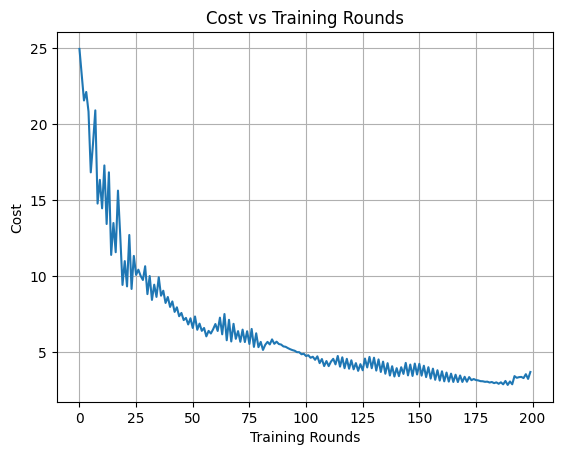

In [ ]:
# Plotting the Cost Function
plt.plot(range(training_rounds),track_cost)
plt.xlabel('Training Rounds')
plt.ylabel('Cost')
plt.title('Cost vs Training Rounds')
plt.grid(True)
plt.show()

In [71]:
# Uncomment if you want to see the predicted and actual digits after training

# # Predicted Digits
# predictions = np.argmax(net.output, axis=1)
# print("Predicted Digits: \n", predictions)

# # Actual Digits/Labels
# actual_labels = np.argmax(targets, axis=1)
# print("Actual Digits:\n", actual_labels)


In [72]:
# Final Forward Pass
net.forward()

# Final Cost
final_cost = cross_entropy_loss(net.output, targets)
print("Final Cost after training: ", final_cost)

Final Cost after training:  3.346333976623137


In [73]:
# Testing The Network Model

test_file_name = 'mnist_test.csv'
df_test = pd.read_csv(test_file_name)

test_labels = df_test['label'].values
test_pixels = df_test.drop('label', axis=1).values.astype(np.uint8)

test_n = len(test_labels)
test_idxs = list(range(test_n))

# Prepare Test Input Batch
test_images = test_pixels[test_idxs].astype(np.float32) / 255.0
test_targets = np.zeros((test_n, 10), dtype=np.float32)
for i in range(test_n):
    test_targets[i, test_labels[test_idxs[i]]] = 1

# Set test images as input
input_layer.data = test_images

# Forward pass on test data
net.forward()

# Get predictions
predictions = np.argmax(net.output, axis=1)
actual_labels = test_labels

In [74]:
# Calculate accuracy
correct = np.sum(predictions == actual_labels)
accuracy = correct / test_n * 100

print(f"Tested on {test_n} images.")
print(f"Accuracy: {accuracy:.2f}% ({correct}/{test_n})")

Tested on 10000 images.
Accuracy: 88.88% (8888/10000)
